In [ ]:
#!pip install torch==1.4.0 torchvision==0.5.0
!pip install gym
!pip install gym[atari]

In [1]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda")

In [4]:
from continuous_cartpole import ContinuousCartPoleEnv 
env = NormalizedEnv(ContinuousCartPoleEnv())

In [ ]:
env.action_space.shape

(1,)

In [ ]:
env.observation_space.shape

(4,)

***

In [3]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [5]:
def plot_durations(episode_durations, goals_done):
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    
    axs[0].plot(durations_t, durations.numpy())

    durations_t, durations = list(map(list, zip(*goals_done)))
    durations = torch.tensor(durations, dtype=torch.float)
    
    fig.suptitle('Training')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Goals done')
    
    axs[1].plot(durations_t, durations.numpy())
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [6]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [7]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [8]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

***

In [9]:
class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, 256)
        self.fc2 = nn.Linear(256, 256)
        self.head = nn.Linear(256, nb_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.head(x))

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(nb_states + nb_actions, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(nb_states + nb_actions, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

In [10]:
BATCH_SIZE = 64
GAMMA = 0.99

# https://spinningup.openai.com/en/latest/algorithms/td3.html
class TD3(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(TD3, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        
        self.actor = Actor(self.nb_states, self.nb_actions)
        self.actor_target = Actor(self.nb_states, self.nb_actions)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=0.0001)

        self.critic = Critic(self.nb_states, self.nb_actions)
        self.critic_target = Critic(self.nb_states, self.nb_actions)
        self.critic_optimizer  = optim.Adam(self.critic.parameters(), lr=0.0001)

        hard_update(self.actor_target, self.actor)
        hard_update(self.critic_target, self.critic)
        
        #Create replay buffer
        self.memory = ReplayMemory(200000)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.15, mu=0.0, sigma=0.2)

        # Hyper-parameters
        self.tau = 0.005
        self.depsilon = 1.0 / 50000
        self.policy_noise=0.2
        self.noise_clip=0.5
        self.policy_freq=2
        self.total_it = 0

        # 
        self.epsilon = 1.0
        self.is_training = True

    def update_policy(self):
        if len(self.memory) < BATCH_SIZE:
            return

        self.total_it += 1
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)

        # Target Policy Smoothing
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action_batch) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip).float()
            
            next_action = (
                self.actor_target(next_state_batch) + noise
            ).clamp(-1.0, 1.0).float()

            # Compute the target Q value
            # Clipped Double-Q Learning
            target_Q1, target_Q2 = self.critic_target(next_state_batch, next_action)
            target_Q = torch.min(target_Q1, target_Q2).squeeze(1)
            target_Q = (reward_batch + GAMMA * not_done_mask  * target_Q).float()
        
        # Critic update
        current_Q1, current_Q2 = self.critic(state_batch, action_batch)
      
        critic_loss = F.mse_loss(current_Q1, target_Q.unsqueeze(1)) + F.mse_loss(current_Q2, target_Q.unsqueeze(1))

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:
            # Compute actor loss
            actor_loss = -self.critic.Q1(state_batch, self.actor(state_batch)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Target update
            soft_update(self.actor_target, self.actor, self.tau)
            soft_update(self.critic_target, self.critic, self.tau)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def observe(self, s_t, a_t, s_t1, r_t, done):
        self.memory.store(s_t, a_t, s_t1, r_t, done)

    def random_action(self):
        return torch.tensor([np.random.uniform(-1.,1.,self.nb_actions)], device=device, dtype=torch.float)

    def select_action(self, s_t, warmup=True, decay_epsilon=True):
        if warmup:
            return self.random_action()

        with torch.no_grad():
            action = self.actor(s_t).squeeze(0)
            action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * self.random_process.sample()).to(device).float()
            action = torch.clamp(action, -1., 1.)

            action = action.unsqueeze(0)
            
            if decay_epsilon:
                self.epsilon -= self.depsilon
            
            return action

In [11]:
class HIRO(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(HIRO, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        self.goal_dim = [0] # cart position [0] and pole angle [2]
      
        self.meta_controller = TD3(nb_states, len(self.goal_dim)).to(device)
        self.max_goal_dist = torch.from_numpy(np.array([1.0])).to(device) # from cartpole-v0 observation space

        self.controller = TD3(nb_states + len(self.goal_dim), nb_actions).to(device)
        self.controller.depsilon = 1.0 / 500000

    def teach_controller(self):
        self.controller.update_policy()
    def teach_meta_controller(self):
        self.meta_controller.update_policy()

    def h(self, state, goal, next_state):
        return goal
        #return state[:,self.goal_dim] + goal - next_state[:,self.goal_dim]
    def intrinsic_reward(self, state, goal, next_state):
        return torch.tensor(1.0 if self.goal_reached(state, goal, next_state) else 0.0, device=device)
        # just L2 norm
        #return -torch.pow(sum(torch.pow(state.squeeze(0)[self.goal_dim] + goal.squeeze(0) - next_state.squeeze(0)[self.goal_dim], 2)), 0.5)
    def goal_reached(self, state, goal, next_state, threshold = 0.1):
        return torch.sign(next_state[:,self.goal_dim] - state[:,self.goal_dim]) == torch.sign(goal)
        #return torch.pow(sum(goal.squeeze(0), 2), 0.5) <= threshold

    # correct goals to allow for use in experience replay
    def off_policy_correction(self, action_seq, state_seq, goal, next_state):
        return goal
        action_seq = torch.stack(action_seq).to(device)
        state_seq = torch.stack(state_seq).to(device)

        mean = (next_state - state_seq[0])[:,self.goal_dim]
        std = 0.5 * (0.5 * self.max_goal_dist)

        candidates = [\
            torch.min(\
                torch.max(torch.from_numpy(np.random.normal(loc=mean.cpu(), scale=std.cpu(), size=len(self.goal_dim)).astype(np.float32)).to(device).unsqueeze(0), -self.max_goal_dist),\
                self.max_goal_dist) for _ in range(8)\
            ]
        candidates.append(mean)
        candidates.append(goal)
        candidates = torch.stack(candidates).to(device)

        surr_prob = [\
              -F.mse_loss(action_seq, self.controller.actor_target(torch.cat([state_seq, state_seq[0][:,self.goal_dim] + candidates[0] - state_seq[:,:,self.goal_dim]], 2).float()))\
              for candidate in candidates]
        index = int(np.argmax(surr_prob))
        goal_hat = candidates[index]
        return goal_hat

    def observe_controller(self, s_t, a_t, s_t1, r_t, done):
        self.controller.memory.store(s_t, a_t, s_t1, r_t, done)
    def observe_meta_controller(self, s_t, a_t, s_t1, r_t, done):
        self.meta_controller.memory.store(s_t, a_t, s_t1, r_t, done)

    def select_goal(self, s_t, warmup=True, decay_epsilon=True):
        return self.meta_controller.select_action(s_t, warmup, decay_epsilon) * self.max_goal_dist
    def select_action(self, s_t, g_t, warmup=True, decay_epsilon=True):
        sg_t = torch.cat([s_t, g_t], 1).float()
        return self.controller.select_action(sg_t, warmup, decay_epsilon)

In [12]:
import time
def train_model():
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    
    agent = HIRO(n_observations, n_actions).to(device)
    
    max_episode_length = None
    
    agent.is_training = True
    episode_reward = 0.
    observation = None
    
    warmup = 100
    num_episodes = 2000 # M
    episode_durations = []
    goal_durations = []

    steps = 0
    c = 100

    for i_episode in range(num_episodes):
        observation = env.reset()
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        
        overall_reward = 0
        episode_steps = 0
        done = False
        goals_done = 0

        while not done:
            goal = agent.select_goal(state, i_episode <= warmup)
            goal_durations.append((steps, goal[:,0]))

            state_seq, action_seq = [], []
            first_goal = goal
            goal_done = False
            total_extrinsic = 0

            while not done and not goal_done:
                joint_goal_state = torch.cat([goal, state], axis=1).float()

                # agent pick action ...
                action = agent.select_action(state, goal, i_episode <= warmup)
                
                # env response with next_observation, reward, terminate_info
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                steps += 1
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                next_goal = agent.h(state, goal, next_state)
                joint_next_state = torch.cat([next_goal, next_state], axis=1).float()
                
                if max_episode_length and episode_steps >= max_episode_length -1:
                    done = True
                    
                extrinsic_reward = torch.tensor([reward], device=device)
                intrinsic_reward = agent.intrinsic_reward(state, goal, next_state).unsqueeze(0)
                
                overall_reward += reward
                total_extrinsic += reward

                goal_done = agent.goal_reached(state, goal, next_state)

                # agent observe and update policy
                agent.observe_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done) #goal_done.item())

                state_seq.append(state)
                action_seq.append(action)

                episode_steps += 1

                if goal_done:
                    goals_done += 1
                
                if goal_done: #or (episode_steps % c) == 0:
                    # perform off-policy correction and store
                    goal_hat = agent.off_policy_correction(action_seq, state_seq, first_goal, next_state)
                    #goal_hat = goal
                    agent.observe_meta_controller(state_seq[0], goal_hat, next_state,  torch.tensor([total_extrinsic], device=device), done)
                    goal_done = True

                    if i_episode > warmup:
                        agent.teach_meta_controller()

                state = next_state
                goal = next_goal
                
                if i_episode > warmup:
                    agent.teach_controller()

        #goal_durations.append((i_episode, goals_done))
        episode_durations.append((i_episode, overall_reward))
        #plot_durations(episode_durations,goal_durations)

        _, dur = list(map(list, zip(*episode_durations)))
        if len(dur) > 100:
            if np.mean(dur[-100:]) >= 195:
                print(f"Solved after {i_episode} episodes!")
                return agent

    return agent

In [72]:
import warnings
warnings.filterwarnings("error")

In [106]:
agent = train_model()

Solved after 1098 episodes!


In [16]:
def eval_model(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    num_episodes = 100

    for l2norm in range(20):

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            state = state * torch.from_numpy(np.ones(4) + (l2norm/10)*(np.random.random(4) - 0.5)).to(device)
            state = state.float()

            done = False
            while not done:
                # select a goal
                goal = agent.select_goal(state, False)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    next_state = next_state *  torch.from_numpy(np.ones(4) + (l2norm/10)*(np.random.random(4) - 0.5)).to(device)
                    next_state = next_state.float()
                    next_goal = agent.h(state, goal, next_state)
                                      
                    overall_reward += reward

                    goal_done = agent.goal_reached(state, goal, next_state)

                    state = next_state
                    goal = next_goal

        episode_durations[l2norm].append(overall_reward / num_episodes)

In [14]:
def plot_norms(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    x, ys = np.array(list(episode_durations.keys())), np.array(list(episode_durations.values()))
    #plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm')
    plt.ylabel('Average Reward')
    
    mu = np.mean(ys, axis=1)
    plt.plot(x / 10, mu)
    stds = np.std(ys, axis = 1)
    plt.fill_between(x / 10, mu + stds , mu - stds, alpha=0.2)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

Solved after 781 episodes!
8 {0: [229.21, 202.94, 362.13, 305.8, 326.8, 435.43, 293.32, 1017.47, 199.59], 1: [283.88, 264.52, 427.64, 341.49, 386.11, 324.62, 348.52, 1503.54, 364.97], 2: [289.02, 257.28, 413.91, 310.3, 348.82, 368.9, 400.31, 1594.73, 387.13], 3: [294.92, 258.38, 418.53, 349.87, 472.37, 394.05, 432.77, 1606.76, 386.69], 4: [293.04, 248.78, 425.69, 353.68, 360.92, 379.39, 437.4, 1599.59, 435.66], 5: [325.62, 259.22, 413.01, 337.03, 422.75, 418.86, 404.53, 1487.71, 406.55], 6: [320.54, 260.72, 430.5, 338.77, 413.08, 406.37, 388.42, 1467.16, 382.38], 7: [313.48, 277.52, 416.97, 304.88, 338.12, 409.86, 391.21, 1356.57, 379.97], 8: [312.93, 262.92, 391.27, 310.63, 330.54, 435.44, 379.7, 1290.08, 413.31], 9: [317.6, 281.52, 404.71, 308.95, 315.82, 463.44, 393.18, 1213.08, 374.71], 10: [324.31, 291.67, 385.82, 309.31, 294.04, 439.66, 386.55, 1121.76, 378.31], 11: [321.45, 276.15, 382.79, 293.02, 264.5, 433.65, 347.81, 1012.55, 383.27], 12: [312.71, 296.35, 360.75, 294.4, 281.4

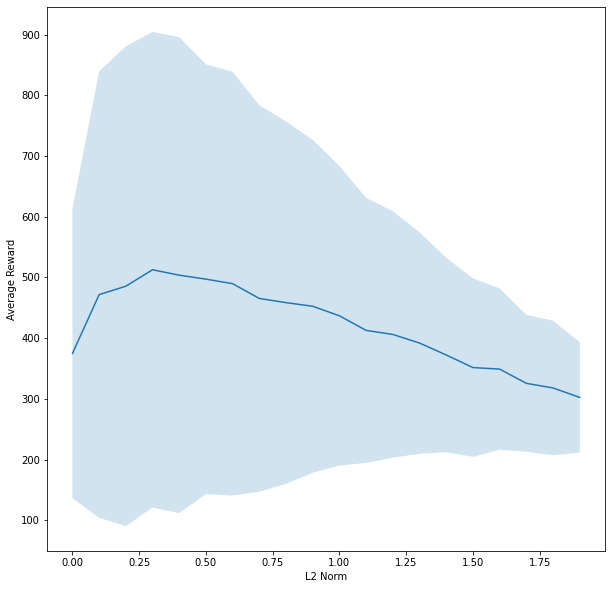

In [ ]:
episode_durations = {}
for l2norm in range(20):
    episode_durations[l2norm] = []

# train 20 models for 200 steps, then eval them
for i in range(20):
    agent = train_model()
    eval_model(agent, episode_durations)
    print(i, episode_durations)
    plot_norms(episode_durations)

plot_norms(episode_durations)
print(episode_durations)